# Examples Using Statsmodels, Seaborn, and Scipy

We'll need these packages for pretty much all the examples:

In [1]:
import pandas as pd

import numpy as np

from scipy.stats import pearsonr, linregress

import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.formula.api as smf

import sqlite3

Seaborn will affect how all of our plots look.  Check out the figure aesthetics to see options for making figures appealing to you:

https://seaborn.pydata.org/tutorial/aesthetics.html

I like things really simple, so I'll use the "whitegrid" style.

In [2]:
import seaborn as sns
sns.set_style("whitegrid", rc={'axes.linewidth': 2.5})
sns.set_context('notebook', font_scale=1.45, rc={"lines.linewidth": 3, "figure.figsize" : (7, 3)})

It will be nice to be able to plot rates and residuals across states.

The `plot_state()` function will show the of a series, on a map of the US.

We'll come back to how to do this, next week.

In [3]:
import sys
sys.path.insert(0,'ex/')

from mapping import *

### Standard Wages Regression

What predicts wages?  Use Integrated Public Use Microsamples (IPUMS) extracted from the 2016 ACS.  

https://usa.ipums.org/usa/index.shtml

In [4]:
ipums = pd.read_csv("data/ipums.csv",
                    usecols = ['YEAR', 'STATEFIP', 'BPL', 'PERWT', 'SEX', 'AGE', 'RACE', 'HISPAN',
                               'EDUC', 'EDUCD', 'DEGFIELD', 'DEGFIELD2', 'INCTOT', 'EMPSTAT'])

The 1990 Census is also in the file, for use below.  We'll have to remove it.

Let's look at employed, working-age adults (ages 25-65).

In [5]:
mask  = (ipums.INCTOT < 9999999)
mask &= (ipums.AGE > 25)
mask &= (ipums.AGE < 65)
mask &= (ipums.YEAR == 2016)
mask &= (ipums.INCTOT > 0)
mask &= (ipums.EMPSTAT == 1)

ipums = ipums[mask].copy()
ipums.reset_index(drop = True, inplace = True)

I'll set up a few simplifed categories for sex, race, ethnicity, and education.  We'll use the `df.loc[cut, var]` syntax to select and set variables in one pass.

In [6]:
ipums.replace({"SEX" : {1 : "Male", 2 : "Female"}}, inplace = True)

# https://usa.ipums.org/usa-action/variables/RACE#codes_section
# https://usa.ipums.org/usa-action/variables/HISPAN#codes_section
ipums["RACEX"] = "Other"
ipums.loc[ipums["RACE"] == 1,  "RACEX"] = "White"
ipums.loc[ipums["HISPAN"] > 0, "RACEX"] = "Hispanic"
ipums.loc[ipums["RACE"] == 2,  "RACEX"] = "Black"

# https://usa.ipums.org/usa-action/variables/EDUC#codes_section
ipums["EDUCX"] = "< HS"
ipums.loc[ipums["EDUCD"] == 63,  "EDUCX"] = "HS"
ipums.loc[ipums["EDUCD"] == 64,  "EDUCX"] = "GED"
ipums.loc[ipums["EDUCD"] >  64,  "EDUCX"] = "< BA"
ipums.loc[ipums["EDUCD"] >= 101, "EDUCX"] = "BA"
ipums.loc[ipums["EDUCD"] >= 114, "EDUCX"] = "ADV"

Defining "categories" allows us to specify an ordering.  This is useful for both plotting and fitting (which is the suppresed category).

In [7]:
ipums["RACE4"] = pd.Series(pd.Categorical(ipums["RACEX"], ordered = True,
                           categories = ["White", "Black", "Hispanic", "Other"]))

ipums["EDUC5"] = pd.Series(pd.Categorical(ipums["EDUCX"], ordered = True,
                           categories = ["< HS", "GED", "HS", "< BA", "BA", "ADV"]))

Listing income in thousands of dollars will make it more readable.

In [8]:
ipums["INCTOTK"] = ipums['INCTOT'] / 1000

This is the first time we've really used seaborn.  You can find the manual here:

https://seaborn.pydata.org/api.html

and a "gallery" of examples, here:

https://seaborn.pydata.org/examples/index.html

Seaborn makes it easy to make attractive plots (but you need to take care in making them useful)!!

Let's start with a standard boxplot.  That's straightforward with pandas/matplotlib...

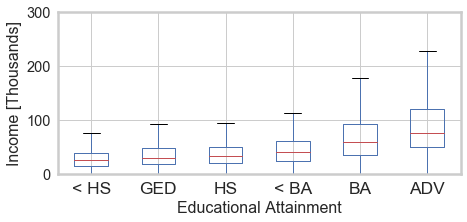

In [9]:
ax = ipums.boxplot(by = "EDUC5", column = "INCTOTK")
ax.set_ylim(0, 300)
ax.set_ylabel("Income [Thousands]")
ax.set_xlabel("Educational Attainment")
plt.suptitle("")
plt.title("")

But I think you can get more-attractive/informative results with seaborn.  In particular, seaborn makes it easy to show multiple variables/categories at once.

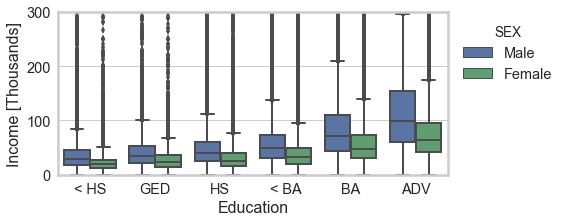

In [10]:
ax = sns.boxplot(data = ipums, x = "EDUC5", y = "INCTOTK", hue = "SEX", linewidth = 2)

ax.get_legend().set_bbox_to_anchor((1.3, 1))
ax.set_ylim(0, 300)
ax.set_ylabel("Income [Thousands]")
ax.set_xlabel("Education")

ax.figure.savefig("income_box.pdf", bbox_inches='tight', pad_inches=0.05)

An alternative that to be aware (but maybe weary?) of is a violin plot.  This will make a kernel density estimate of the variables.

The problem is that the bandwidth (`bw`) for the kernel density can dramatically affect the presentation, and you should take care so that the density does not extend in non-sensical regions (`cut`).

Another alternative is the "letter value" plot, which is graphically compelling but so seldom used that no one will understand what you're doing...

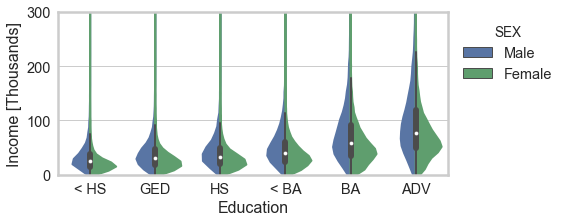

In [11]:
ax = sns.violinplot(x = "EDUC5", y = "INCTOTK", data = ipums,
                    hue = "SEX", split = True, bw = 0.1, cut = 0,
                    linewidth = 2)

ax.get_legend().set_bbox_to_anchor((1.3, 1))
ax.set_ylim(0, 300)
ax.set_ylabel("Income [Thousands]")
ax.set_xlabel("Education")

ax.figure.savefig("income_violin.pdf", bbox_inches='tight', pad_inches=0.05)

So we can see the relationships between education, sex and earnings.  Let's make this a bit more formal. 

With `statsmodels`, we can "trivially" define a weighted least squares model for log income.

In this regression, any case that is either a string (`SEX`) or a categorial (`RACE4` and `EDUC5`) will be treated as a category/fixed effect.  I've already restricted this to be positive to sidestep the log(0) problem.

We can look at interactions *and* alone with "`*`" and, interactions _only_, with "`:`".

In [12]:
formula = "np.log(INCTOT) ~ 1" # AGE + RACE4 + EDUC5 + SEX + C(STATEFIP)"
ols = smf.wls(formula = formula, data = ipums, weights = ipums["PERWT"])
model = ols.fit()
model.summary()

/Users/jsaxon/anaconda/lib/python3.5/site-packages/statsmodels/regression/linear_model.py:1396: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ess/self.df_model


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:         np.log(INCTOT)   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       inf
Date:                Sun, 12 Nov 2017   Prob (F-statistic):                nan
Time:                        21:47:50   Log-Likelihood:            -1.7247e+06
No. Observations:             1154227   AIC:                         3.449e+06
Df Residuals:                 1154226   BIC:                         3.449e+06
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.5793      0.001   1.19e+04      0.000      10.578      10.581
==============================================================================
Omnibus:                   466950.300   Durbin-Watson:                   1.889
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8952129.412
Skew:                          -1.470   Prob(JB):                         0.00
Kurtosis:                      16.323   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Does this make sense??  Without other covariates, does the weighted mean match the intercept?  How much money is this, anyway??

In [13]:
lnw = (np.log(ipums.INCTOT) * ipums.PERWT).sum() / ipums.PERWT.sum()
lnw, np.exp(lnw)

(10.579251527275819, 39310.680417171774)

We can get a pandas Series of the parameter estimates (`model.params`) or residuals (`model.resid`):

In [14]:
model.params

Intercept    10.579252
dtype: float64

Including and examining fixed effects across states, we get a hint of variable cost of living, among other factors...

In [15]:
state_vals = {1 : 0.0}
for k, v in model.params.items():
    
    if "STATEFIP" not in k: continue
    
    f = int(k.replace("C(STATEFIP)[T.", "").replace("]", ""))
    state_vals[f] = float(v)
    
# plot_states(state_vals)

### Do states with higher activity/exercise levels have lower average BMIs?

#### Behavioral Risk Factor Surveillance System

https://www.cdc.gov/brfss/annual_data/annual_2016.html

This file is about 1GB raw, so I've reduced it to what we really need:

```
cdc = pd.read_sas("data/LLCP2016.xpt", format = "xport")
cdc.rename(columns = {"_STATE" : "STATE", "_BMI5" : "BMI", "_LLCPWT" : "LLCPWT"}, inplace = True)
cdc.STATE = cdc.STATE.astype(int)
cdc[['STATE', 'BMI', 'LLCPWT', 'SEX', 'MARITAL', 'EDUCA']].to_csv("data/BRFSS_bmi_redux.csv", index = False)```

In [16]:
cdc = pd.read_csv("data/BRFSS_bmi_redux.csv")

Pandas actually doesn't build in a weighted mean function (!).  We have to write this ourselves, and `apply()` it.

This is a more-technical and faster method for an entire dataframe.  There's a one-off example for the median of an income distribution, below.

In [17]:
def weighted_mean(grp): return grp._get_numeric_data().multiply(grp['LLCPWT'], axis=0).sum()/grp['LLCPWT'].sum()
cdc_bmi = cdc.groupby("STATE").apply(weighted_mean)["BMI"].reset_index()

cdc_bmi.head()

,STATE,BMI
0,1,2650.677887
1,2,2643.861457
2,4,2499.411934
3,5,2639.506359
4,6,2448.739724


Revisiting our old friend, the Time Use Survey, we can find out what fraction of people exercise, per state.

Mea culpa: I'm not worrying about the weights, here.

In [18]:
con = sqlite3.connect("data/atus.sqlite")

state_exercise = """
SELECT 
  state_code STATE, avg(ex > 0) Exercise, count(ex) N
FROM (
  SELECT 
    state_code, 
    sum((activity_code/100 = 1301) * duration) ex 
  FROM respondents 
  JOIN activities ON
    respondents.case_id = activities.case_id
  JOIN cps ON
    respondents.case_id = cps.case_id AND
    cps.line_no = 1 
  GROUP BY respondents.case_id)
GROUP BY state_code;
"""

state_exercise = pd.read_sql_query(state_exercise, con)
state_exercise.head()

,STATE,Exercise,N
0,1,0.129404,2867
1,2,0.189911,337
2,4,0.197983,2975
3,5,0.145008,1793
4,6,0.213824,17028


Now we need to combine these two datasets.  They both have the FIPS code in the "STATE" variable, so we're good to go!

In [19]:
state_ex_bmi = pd.merge(state_exercise, cdc_bmi).set_index("STATE")

We'll want a different figsize, for these.

In [20]:
sns.set_context('notebook', font_scale=1.45, rc={"lines.linewidth": 3, "figure.figsize" : (7, 4.5)})

Let's just start this time by visualizing the correlation between these variables.

I'll use the the Seaborn `regplot()` function:

https://seaborn.pydata.org/generated/seaborn.regplot.html

(You can read up on the similarities and small differences WRT the `lmplot()` function.)

I will also plot a line at 2500 -- the value for overweight.  This is averages over a state!  Most states have an average BMI over the overweight line!!

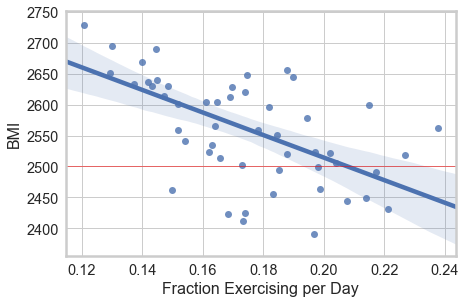

In [21]:
ax = sns.regplot(x = "Exercise", y = "BMI", data = state_ex_bmi, robust = True)
ax.set_xlabel("Fraction Exercising per Day")
plt.plot([0, 1], [2500, 2500], 'r-', lw=0.5)

Seaborn doesn't tell us the actual values of the model, though, but we can get those from statsmodels or scipy.  They had better be the same!!

In [22]:
model = smf.ols(formula = "BMI ~ Exercise", data = state_ex_bmi).fit()
model.params

Intercept    2859.149521
Exercise    -1727.022724
dtype: float64

In [23]:
linregress(state_ex_bmi["Exercise"], state_ex_bmi["BMI"])

LinregressResult(slope=-1727.0227242793487, intercept=2859.1495211354199, rvalue=-0.56889915657873702, pvalue=1.3259801793275351e-05, stderr=356.65775634205454)

While we're at it, let's get the correlation:

In [24]:
pearsonr(state_ex_bmi["Exercise"], state_ex_bmi["BMI"])

(-0.56889915657873691, 1.3259801793275418e-05)

Sanity check: pause to plot these on a map.

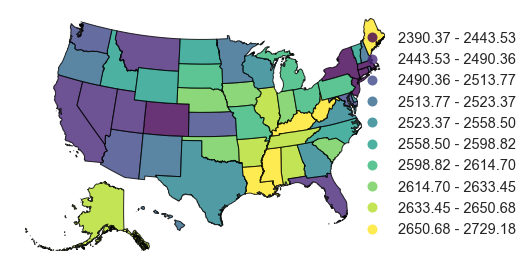

In [25]:
plot_states(state_ex_bmi["BMI"])

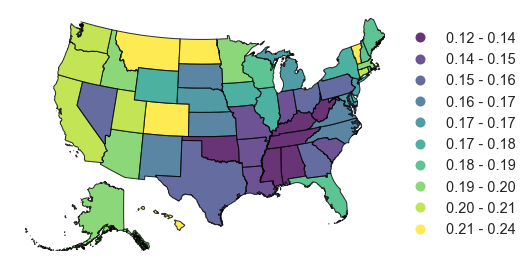

In [26]:
plot_states(state_ex_bmi["Exercise"])

## Do people exercise more on nice days?

Since we record the day on which the ATUS diary is recorded, we can actually look up the weather on that day.  We'll treat this as an example, next week.

Restricting ourselves to Illinois, we can take the weather at Midway as an approximation for the entire state.  60% of Illinoisans live in Cook, Lake, Dupage, and Will Counties.

In [27]:
temp = pd.read_csv("data/MDW.csv", names = ["Date", "Temperature [F]", "Precipitation [In]"], header = 0,
                   parse_dates = ["Date"], index_col = "Date")

You must be very careful with time zones.  This file is saved in UTC.  There is really no rhyme or reason to this, but the syntax for converting to local time works like this:

In [28]:
import pytz
temp.set_index(temp.index.tz_localize(pytz.UTC).tz_convert(pytz.timezone('US/Central')), inplace = True)

There are a lot of measurements with T = -9999.  These are clearly just sensor problems, so we'll remove them.

In [29]:
temp = temp[temp["Temperature [F]"] > -2000].copy()

We can then groupby date.  Alternatively, we could `resample()`, but the sql query will give us dates instead of datetimes, so we might as well cut to the chase and get a "date" on the index.

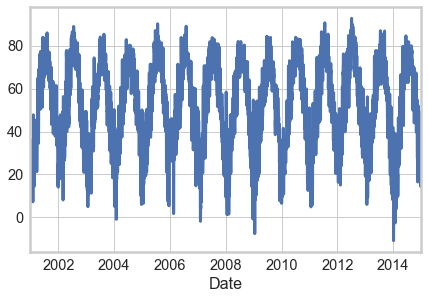

In [30]:
temp.resample("1D").mean()["Temperature [F]"].plot()

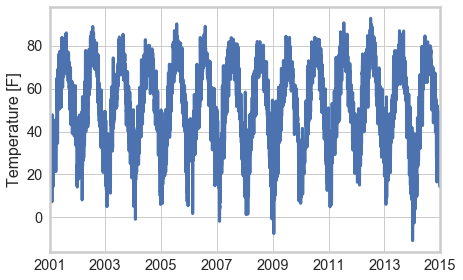

In [31]:
temp["Date"] = temp.index.date
temp = temp.groupby("Date").mean()[["Temperature [F]"]]

ax = temp["Temperature [F]"].plot()
ax.set_xlabel("")
ax.set_ylabel("Temperature [F]")

This is very closely analogous to what we've done before, but I'm recording _per person_ the time spent exercising, instead of whether or not they exercised at all.  At the end I convert the date strings to a date.

In [32]:
il_exercise_date = """
SELECT 
  diary_date Date,
  sum((activity_code/100 = 1301) * duration) ex 
FROM respondents 
JOIN activities ON
  respondents.case_id = activities.case_id
JOIN cps ON
  respondents.case_id = cps.case_id AND
  cps.line_no = 1 
WHERE
  state_code = 17
GROUP BY respondents.case_id;
"""

il_exercise = pd.read_sql_query(il_exercise_date, con)
il_exercise["Date"] = pd.to_datetime(il_exercise.Date, format='%Y%m%d').dt.date
il_exercise.set_index("Date", inplace = True)

Now join together the two datasets: weather and time use.

In [33]:
il_ex_temp = il_exercise.join(temp, how = "inner")
il_ex_temp.rename(columns = {"ex" : "Exercise [Minutes]"}, inplace = True)

Make a pandas scatter plot of this:

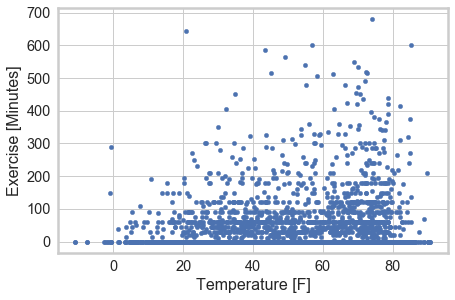

In [34]:
il_ex_temp.plot(kind = "scatter", x = "Temperature [F]", y = "Exercise [Minutes]")

We can plot a simple regression with seaborn:

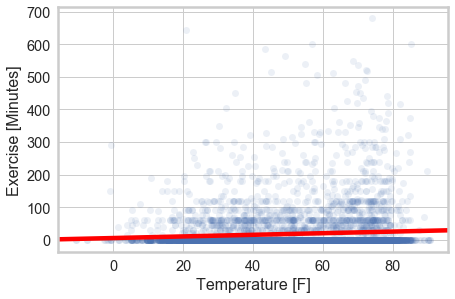

In [35]:
sns.regplot(data = il_ex_temp, x = "Temperature [F]", y = "Exercise [Minutes]",
            scatter_kws = {"alpha" : 0.1}, line_kws = {"color" : "red"})

... but it should be obvious that there are extensive and intensive margins at play: a likelihood of exercising _at all_, and the average length of exercising, 

Let's separate these out.  We'll make two new variables: 10-degree temperature bins, and an indicator for exercising or not.

In [36]:
il_ex_temp["TempIF"] = (il_ex_temp["Temperature [F]"]/10).astype(int) * 10 + 5
il_ex_temp["ExBool"] = il_ex_temp["Exercise [Minutes]"] > 0

First plot the extensive part -- what fraction of Illinoisans are exercising?

I will use a seaborn `pointplot()`, to plot the averages, with bootstrapped 95% CI's:

https://seaborn.pydata.org/generated/seaborn.pointplot.html#seaborn.pointplot

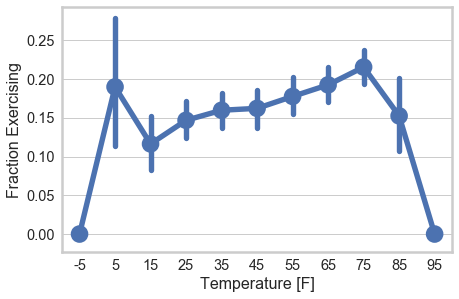

In [37]:
ax = sns.pointplot(data = il_ex_temp, x = "TempIF", y = "ExBool", 
                   ci = 95, line_kws = {"color" : "red"})
ax.set_xlabel("Temperature [F]")
ax.set_ylabel("Fraction Exercising")

Same thing, for the intensive margin.  Considering only those who exercise, how much do they exercise??

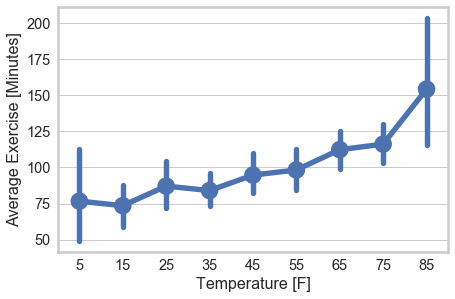

In [38]:
ax = sns.pointplot(data = il_ex_temp[il_ex_temp["ExBool"]], x = "TempIF", y = "Exercise [Minutes]", 
                   line_kws = {"color" : "red"})
ax.set_xlabel("Temperature [F]")
ax.set_ylabel("Average Exercise [Minutes]")

## Does paying attention to children help them to succeed?

We can use the IPUMS data used above for wages, for educational attainment.  The file contains both the 2016 ACS and the 1990 Census.

We'll filter out the 25-35 year-old population living in a state in 1990, and the 25-35 year-old population that _grew up in_ (was born in) a state, as measured in 2016.

In [39]:
ipums = pd.read_csv("data/ipums.csv")

Mask out the parts we're interested in.  I'm going to stick to one person per household

Make two variables to record educational attainment.  See the codes:

https://usa.ipums.org/usa-action/variables/EDUC#codes_section

In [40]:
ipums1990 = ipums.loc[(ipums.YEAR == 1990) & (25 < ipums.AGE) & (ipums.AGE < 35), \
                      ["INCTOT", "STATEFIP", "EDUCD", "PERWT"]].copy()

ipums1990["HS"] = ipums1990.EDUCD > 61
ipums1990["BA"] = ipums1990.EDUCD >= 101

To aggregate, we can use the same style of weighted mean that we had earlier, but we'll need to also write a function for the median income (mean income is a weird object).

In [41]:
def weighted_mean(grp): return grp._get_numeric_data().multiply(grp['PERWT'], axis=0).sum()/grp['PERWT'].sum()

def weighted_inc_median(grp):

    s = grp.sort_values(by = "INCTOT")
    c = grp.loc[grp["INCTOT"] < 8e6, "PERWT"].sum() / 2.0
    q = s["PERWT"].cumsum() 
    
    median = s.loc[q >= c, "INCTOT"].iloc[0]
    
    return median

In [42]:
grouped = ipums1990.groupby("STATEFIP")
ipums1990_agg = grouped.apply(weighted_mean)[["BA", "HS"]]
ipums1990_agg["Income"] = grouped.apply(weighted_inc_median)

ipums1990_agg.head()

,BA,HS,Income
STATEFIP,,,
1,0.186521,0.802230,13000
2,0.194008,0.908477,18873
4,0.205862,0.836676,15000
5,0.148586,0.805173,12000
6,0.231740,0.784066,16500


Now basically the same thing for 2016 -- the "kids":

In [43]:
ipums2016 = ipums.loc[(ipums.YEAR == 2016) & (25 < ipums.AGE) & (ipums.AGE < 35), \
                      ["BPL", "EDUCD", "PERWT"]].copy()

ipums2016["HS"] = ipums2016.EDUCD > 61
ipums2016["BA"] = ipums2016.EDUCD >= 101

ipums2016_agg = ipums2016.groupby("BPL").apply(weighted_mean)[["HS", "BA"]].reset_index()

Merge these two datasets together.  It will the `STATEFIP` left, and the `BPL` (birthplace) on the right:

In [44]:
ipums_merged = pd.merge(ipums1990_agg.rename(columns = {"HS" : "HS_home", "BA" : "BA_home", "Income" : "INC_home"}).reset_index(), 
                        ipums2016_agg, left_on = "STATEFIP", right_on = "BPL")

ipums_merged = ipums_merged.set_index("BPL")[["HS_home", "BA_home", "INC_home", "HS", "BA"]]
ipums_merged.head()

,HS_home,BA_home,INC_home,HS,BA
BPL,,,,,
1,0.802230,0.186521,13000,0.884915,0.287950
2,0.908477,0.194008,18873,0.932642,0.297242
4,0.836676,0.205862,15000,0.893717,0.267525
5,0.805173,0.148586,12000,0.914226,0.283248
6,0.784066,0.231740,16500,0.920746,0.326210


Let's do a simple regression to see how this works out.

I'll also plot y = x, to show the jump in overall attainment, between generations.  (Here it's 35 years -- well over a generation...)

(0.1, 0.6)

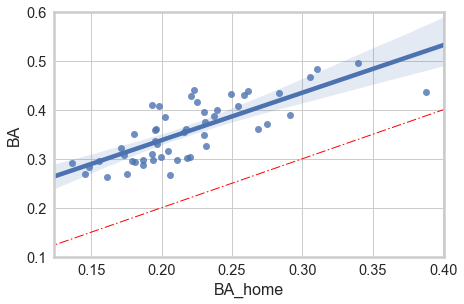

In [45]:
ax = sns.regplot(x = "BA_home", y = "BA", data = ipums_merged)
plt.plot([0, 1], [0, 1], 'r-.', lw=1)
ax.set_ylim(0.1, 0.6)

On a map of the US, who's doing well??

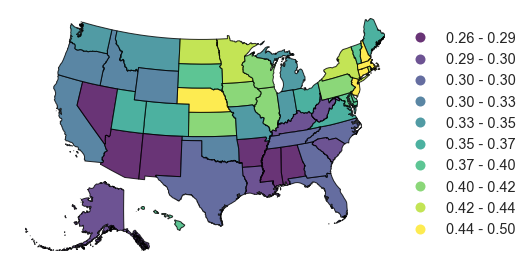

In [46]:
plot_states(ipums_merged["BA"])

Use statsmodels to regress current education on "parental" education and income:

In [47]:
ols = smf.ols(formula = "BA ~ BA_home + HS_home + np.log(INC_home)", data = ipums_merged)
model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     BA   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     54.42
Date:                Sun, 12 Nov 2017   Prob (F-statistic):           2.52e-15
Time:                        21:49:31   Log-Likelihood:                 107.60
No. Observations:                  51   AIC:                            -207.2
Df Residuals:                      47   BIC:                            -199.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.4625      0.368     -1.256      0.215      -1.204       0.279
BA_home              0.7690      0.139      5.551      0.000       0.490       1.048
HS_home              0.6610      0.116      5.719      0.000       0.428       0.893
np.log(INC_home)     0.0087      0.043      0.201      0.842      -0.078       0.095
==============================================================================
Omnibus:                        1.302   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.522   Jarque-Bera (JB):                1.323
Skew:                          -0.332   Prob(JB):                        0.516
Kurtosis:                       2.575   Cond. No.                         877.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Take a look at a scatter plot of the residuals WRT BA Home, and on a map.  These are still fairly large.

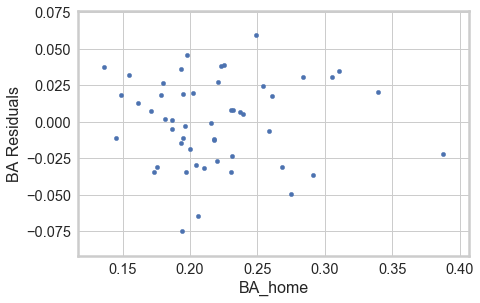

In [48]:
ipums_merged["BA Residuals"] = model.resid
ipums_merged.plot(kind = "scatter", x = "BA_home", y = "BA Residuals")

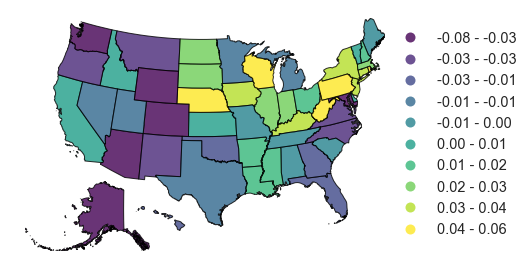

In [49]:
plot_states(ipums_merged["BA Residuals"])

Now let's bring in the time spent with children:

In [50]:
direct = """
SELECT 
  respondents.case_id,
  race, hispanic_origin as hispanic, edited_sex as sex,
  family_income, state_code, census_division,
  cps.years_education AS adult_education, 
  SUM(((activity_code/100 IN (301, 302, 303)) OR activity_code = 180381) * duration/60.) AS 'child_attention'
FROM respondents
INNER JOIN cps ON 
  respondents.case_id = cps.case_id AND 
  respondents.line_no = cps.line_no
INNER JOIN activities ON
  respondents.case_id = activities.case_id
INNER JOIN roster ON
  respondents.case_id = roster.case_id AND
  respondents.line_no = roster.line_no
WHERE
  number_of_hh_children > 0 AND
  edited_labor_force_status < 3
GROUP BY respondents.case_id;
"""

df = pd.read_sql_query(direct, con)

df["EDCAT"] = "0DROPOUT"
df.loc[df.adult_education >= 13, "EDCAT"] = "1HSGRAD"
df.loc[df.adult_education == 17, "EDCAT"] = "2BA"
df.loc[df.adult_education >  17, "EDCAT"] = "3ADV"

df.loc[df.family_income == 0, "family_income"] += 1
direct_engagement = df[df.family_income > 0].copy()

Get the average time spent with kids (`groupby()`) by state, and plot it.

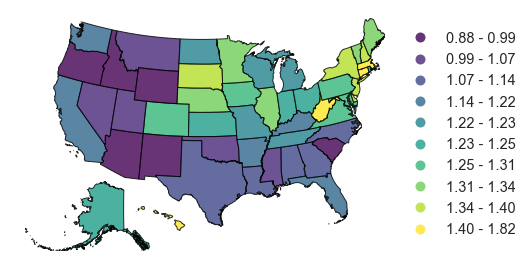

In [51]:
ipums_merged["Attention"] = direct_engagement.groupby("state_code").mean()[["child_attention"]]
plot_states(ipums_merged["Attention"])

What predicts this?  Run a regression with education, income, sex, and state fixed effects.

This is almost not a regression: except for the family income, we're just de-meaning the data.  But it's convenient.

In [52]:
ols = smf.ols(formula = "child_attention ~ C(EDCAT) + np.log(family_income) + C(sex) + C(state_code)",
              data = direct_engagement)
model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        child_attention   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     62.36
Date:                Sun, 12 Nov 2017   Prob (F-statistic):               0.00
Time:                        21:49:40   Log-Likelihood:            -1.0150e+05
No. Observations:               52250   AIC:                         2.031e+05
Df Residuals:                   52194   BIC:                         2.036e+05
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.3617      0.087      4.156      0.000       0.191       0.532
C(EDCAT)[T.1HSGRAD]       0.5500      0.025     21.856      0.000       0.501       0.599
C(EDCAT)[T.2BA]           1.0351      0.028     37.073      0.000       0.980       1.090
C(EDCAT)[T.3ADV]          1.1581      0.031     37.392      0.000       1.097       1.219
C(sex)[T.2]               0.4690      0.015     31.454      0.000       0.440       0.498
C(state_code)[T.2]        0.0516      0.160      0.322      0.748      -0.263       0.366
C(state_code)[T.4]       -0.0833      0.083     -0.999      0.318      -0.247       0.080
C(state_code)[T.5]        0.0551      0.096      0.573      0.567      -0.134       0.244
C(state_code)[T.6]        0.0962      0.066      1.466      0.143      -0.032       0.225
C(state_code)[T.8]        0.1315      0.079      1.661      0.097      -0.024       0.287
C(state_code)[T.9]        0.2203      0.090      2.437      0.015       0.043       0.398
C(state_code)[T.10]       0.1940      0.142      1.367      0.172      -0.084       0.472
C(state_code)[T.11]       0.4852      0.222      2.190      0.029       0.051       0.919
C(state_code)[T.12]       0.0036      0.070      0.051      0.959      -0.134       0.142
C(state_code)[T.13]       0.0179      0.076      0.235      0.815      -0.132       0.168
C(state_code)[T.15]       0.2063      0.144      1.430      0.153      -0.077       0.489
C(state_code)[T.16]      -0.1362      0.112     -1.212      0.226      -0.356       0.084
C(state_code)[T.17]       0.1814      0.071      2.548      0.011       0.042       0.321
C(state_code)[T.18]       0.1365      0.078      1.741      0.082      -0.017       0.290
C(state_code)[T.19]       0.1601      0.086      1.866      0.062      -0.008       0.328
C(state_code)[T.20]       0.1458      0.087      1.668      0.095      -0.025       0.317
C(state_code)[T.21]       0.0698      0.084      0.830      0.406      -0.095       0.235
C(state_code)[T.22]      -0.0131      0.091     -0.143      0.886      -0.192       0.166
C(state_code)[T.23]       0.2075      0.120      1.735      0.083      -0.027       0.442
C(state_code)[T.24]       0.1020      0.080      1.270      0.204      -0.055       0.259
C(state_code)[T.25]       0.2409      0.078      3.074      0.002       0.087       0.395
C(state_code)[T.26]       0.0787      0.073      1.078      0.281      -0.064       0.222
C(state_code)[T.27]       0.1572      0.076      2.078      0.038       0.009       0.305
C(state_code)[T.28]      -0.0253      0.099     -0.256      0.798      -0.218       0.168
C(state_code)[T.29]       0.1063      0.078      1.364      0.173      -0.046       0.259
C(state_code)[T.30]      -0.0730      0.133     -0.550      0.583      -0.333       0.187
C(state_code)[T.31]    

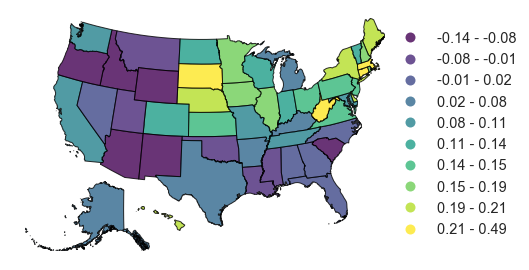

In [53]:
state_vals = {1 : 0.0}
for k, v in model.params.items():
    
    if "state_code" not in k: continue
    
    f = int(k.replace("C(state_code)[T.", "").replace("]", ""))
    state_vals[f] = float(v)
    
ipums_merged["Attention Fixed Effects"] = pd.Series(state_vals)
plot_states(state_vals)

Now we have a dataset with all of these things together!

In [54]:
ipums_merged.head()

,HS_home,BA_home,INC_home,HS,BA,BA Residuals,Attention,Attention Fixed Effects
BPL,,,,,,,,
1,0.802230,0.186521,13000,0.884915,0.287950,-0.005188,1.106261,0.000000
2,0.908477,0.194008,18873,0.932642,0.297242,-0.075105,1.236282,0.051578
4,0.836676,0.205862,15000,0.893717,0.267525,-0.064494,0.964623,-0.083267
5,0.805173,0.148586,12000,0.914226,0.283248,0.018031,1.144703,0.055135
6,0.784066,0.231740,16500,0.920746,0.326210,0.008238,1.171354,0.096166


Compare the residuals of the BA regression with the state categories from the time with children.  I'd say there's a correlation:

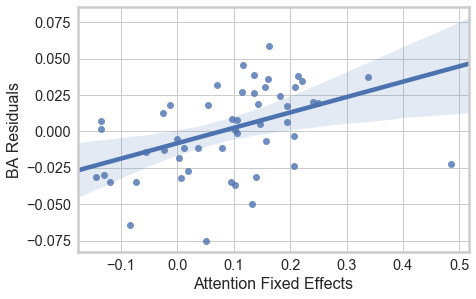

In [55]:
sns.regplot(data = ipums_merged, x = "Attention Fixed Effects", y = "BA Residuals", robust = True)

Try adding attention to children to the model.  Is it significant?

What stories can be told about education in the mountain states?

In [56]:
ols = smf.ols(formula = "BA ~ BA_home + HS_home + np.log(INC_home) + Attention", data = ipums_merged)
ols.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     BA   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     51.92
Date:                Sun, 12 Nov 2017   Prob (F-statistic):           1.75e-16
Time:                        21:49:54   Log-Likelihood:                 112.93
No. Observations:                  51   AIC:                            -215.9
Df Residuals:                      46   BIC:                            -206.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.4676      0.335     -1.394      0.170      -1.143       0.207
BA_home              0.5474      0.143      3.824      0.000       0.259       0.836
HS_home              0.6273      0.106      5.934      0.000       0.415       0.840
np.log(INC_home)     0.0039      0.039      0.100      0.921      -0.075       0.083
Attention            0.1053      0.032      3.272      0.002       0.041       0.170
==============================================================================
Omnibus:                        2.527   Durbin-Watson:                   1.760
Prob(Omnibus):                  0.283   Jarque-Bera (JB):                1.610
Skew:                          -0.374   Prob(JB):                        0.447
Kurtosis:                       3.446   Cond. No.                         885.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""